In [1]:
#Python > 3.5 version is required
import sys
assert sys.version_info>=(3,5)

##We will be using Sklearn for our project and hence we would need a version >=0.20
import sklearn
sklearn.__version__>="0.20"

True

In [2]:
#We mute the warnings
import warnings as w
w.filterwarnings('always')
w.filterwarnings("ignore", category=DeprecationWarning)

## Importing the relevant libraries

In [3]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("talk", font_scale=0.8)
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import re
from scipy.stats import skew,norm
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold,ShuffleSplit,train_test_split,GridSearchCV,StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

##Classifiers
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [103]:
## We start with importing the data
df = pd.read_csv(r"bengaluru_house_prices.csv",sep=',')
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [104]:
## Our target variable is the price which we separate from the data frame.
# cols = [c for c in df.columns if c!='price']
# x = df[cols]
# y = df.price

## Data cleaning

__We check the columns having null values__

In [105]:
n = df.isnull().sum()
n[n>0]

location       1
size          16
society     5502
bath          73
balcony      609
dtype: int64

In [106]:
df.shape

(13320, 9)

__* Firstly, the society column has a lot of null values (almost 50%), hence we remove that from our data.__

__* Secondly, the column availability has majority(around 80%) of values as 'Ready to move' with the rest being dates when the property are available. So, due to this we drop this column as well from our data__

__* In the other columns with null values, we fill the values with the unique values of that column in the porportion of the occurences of the unique values. For example, if out 110 values x occurs 60 times, y occurs 25 times & z occurs 15 times then the remaining 10 null values would be filled with x,y,z in in aporportion such that x occurs 60% of the times out of 10, y occurs roughly 25% of the times and so forth__

In [107]:
# Dropping the two columns discussed
df.drop(['availability','society'],axis=1, inplace=True)
df.head(3)

,area_type,location,size,total_sqft,bath,balcony,price
0,Super built-up Area,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07
1,Plot Area,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00
2,Built-up Area,Uttarahalli,3 BHK,1440,2.0,3.0,62.00


In [108]:
## Replacing the null values
print(df.balcony.value_counts(normalize=True))

2.0    0.402250
1.0    0.385257
3.0    0.131540
0.0    0.080954
Name: balcony, dtype: float64


In [109]:
df['balcony'] = df['balcony'].fillna(pd.Series(np.random.choice([0.0,1.0,2.0,3.0],p=[0.08,0.39,0.40,0.13]
                                                                ,size=len(df))))
print(df.balcony.value_counts(normalize=True))

2.0    0.402027
1.0    0.386261
3.0    0.131682
0.0    0.080030
Name: balcony, dtype: float64


In [110]:
## In the sizer column since majority are either 2 BHK or 3BHK hence we only fill the 16 null values with these.
df['size'].value_counts()[:3]

2 BHK        5199
3 BHK        4310
4 Bedroom     826
Name: size, dtype: int64

In [111]:
df['size'] = df['size'].fillna(pd.Series(np.random.choice(['2 BHK','3 BHK'],p=[0.6,0.4],size=len(df))))
print(df['size'].value_counts()[:2])

2 BHK    5209
3 BHK    4316
Name: size, dtype: int64


In [112]:
df.bath.value_counts()[:4]

2.0    6908
3.0    3286
4.0    1226
Name: bath, dtype: int64

In [113]:
df['bath'] = df['bath'].fillna(pd.Series(np.random.choice([2.0,3.0,4.0],p=[0.6,0.3,0.1],size=len(df))))
df.bath.value_counts()[:4]

2.0    6947
3.0    3311
4.0    1235
Name: bath, dtype: int64

In [114]:
## For location since we just have one null hence we use forward fill
df['location'].fillna(method='ffill',inplace=True)
df.location.isnull().sum()

0

## Feature Engineering & Exploratory Data Analysis

__Now we notice that the size column has 4 BHK and then 4 bedrooms as unique values. What we do is we consider them as 4 only rather than considering them as 2 separate values__

In [115]:
df['bhk'] = df['size'].apply(lambda x : int(x.split(' ')[0])).astype('int64')

In [116]:
## We remove the original 'size' column

df.drop(['size'],axis=1,inplace=True)
df.head()

,area_type,location,total_sqft,bath,balcony,price,bhk
0,Super built-up Area,Electronic City Phase II,1056,2.0,1.0,39.07,2
1,Plot Area,Chikka Tirupathi,2600,5.0,3.0,120.00,4
2,Built-up Area,Uttarahalli,1440,2.0,3.0,62.00,3
3,Super built-up Area,Lingadheeranahalli,1521,3.0,1.0,95.00,3
4,Super built-up Area,Kothanur,1200,2.0,1.0,51.00,2


__Now we explore the total square feet feature which is one of the essential features for the prediction of the price of a house__

In [117]:
df.total_sqft.unique()[:100]

## Amid all the values you might come across some ranges rather than scalar values. 
## So we should change them into numerical values

array(['1056', '2600', '1440', '1521', '1200', '1170', '2732', '3300',
       '1310', '1020', '1800', '2785', '1000', '1100', '2250', '1175',
       '1180', '1540', '2770', '600', '1755', '2800', '1767', '510',
       '1250', '660', '1610', '1151', '1025', '2100 - 2850', '1075',
       '1760', '1693', '1925', '700', '1070', '1724', '1290', '1143',
       '1296', '1254', '1330.74', '970', '1459', '800', '869', '1270',
       '1670', '2010', '1185', '1600', '3010 - 3410', '1500', '1407',
       '840', '4395', '845', '5700', '1160', '3000', '1140', '1220',
       '1350', '1005', '500', '1358', '1569', '1240', '2089', '1206',
       '1150', '2511', '460', '4400', '1660', '2957 - 3450', '1326',
       '1325', '1499', '1665', '708', '1060', '710', '1450', '2894',
       '1330', '2502', '650', '2400', '1007', '966', '1630', '1640',
       '782', '1260', '1413', '1116', '1530', '3700', '2497'],
      dtype=object)

In [118]:
def convert_float(x):
    try:
        float(x)
    except:
        return False
    return True

## Now we look for cases where the value is not a scalar value as a character range would not be convreted to a floating point

In [119]:
df[~df['total_sqft'].apply(convert_float)]

,area_type,location,total_sqft,bath,balcony,price,bhk
30,Super built-up Area,Yelahanka,2100 - 2850,4.0,0.0,186.000,4
56,Built-up Area,Devanahalli,3010 - 3410,2.0,2.0,192.000,4
81,Built-up Area,Hennur Road,2957 - 3450,2.0,2.0,224.500,4
122,Super built-up Area,Hebbal,3067 - 8156,4.0,0.0,477.000,4
137,Super built-up Area,8th Phase JP Nagar,1042 - 1105,2.0,0.0,54.005,2
...,...,...,...,...,...,...,...
12990,Super built-up Area,Talaghattapura,1804 - 2273,3.0,0.0,122.000,3
13059,Super built-up Area,Harlur,1200 - 1470,2.0,0.0,72.760,2
13240,Super built-up Area,Devanahalli,1020 - 1130,2.0,3.0,52.570,1
13265,Super built-up Area,Hoodi,1133 - 1384,2.0,0.0,59.135,2


Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which we could convert to square ft using unit conversion.

In [120]:
def convert_sq_ft(x):
    tokens = x.split('-')
    if len(tokens)==2:
        return (float(tokens[0]) + float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None
    
df['total_sqft']=df['total_sqft'].apply(lambda x : convert_sq_ft(x))

#### Hence we will naturally have some null values inserted where we might have cases like square meters or all. We simply remove those rows from the data frame as these are just 46 in number as shown below.

In [121]:
print(df.shape[0])
df[df['total_sqft'].isna()].shape[0]

13320


46

In [122]:
## Hence we have removed the 46 rows with null values
df = df[~df['total_sqft'].isna()]
df.shape[0]

13274

### Introducing a new feature called `price per square feet`

In [123]:
## Price is expressed in 0.1 million or lakhs.
df['price_per_sqFeet'] = df['price']*100000/df['total_sqft']
df.head()

,area_type,location,total_sqft,bath,balcony,price,bhk,price_per_sqFeet
0,Super built-up Area,Electronic City Phase II,1056.0,2.0,1.0,39.07,2,3699.810606
1,Plot Area,Chikka Tirupathi,2600.0,5.0,3.0,120.00,4,4615.384615
2,Built-up Area,Uttarahalli,1440.0,2.0,3.0,62.00,3,4305.555556
3,Super built-up Area,Lingadheeranahalli,1521.0,3.0,1.0,95.00,3,6245.890861
4,Super built-up Area,Kothanur,1200.0,2.0,1.0,51.00,2,4250.000000


#### Now we look into the location feature of our data

##### After finding the unique values, we realize that there are around 1.3k data points which are categorical in nature. 

##### Hence, after performing something like a one hot encoding would lead to a lot of new features (around 1.3k only). This is also known as `Curse of dimensionality`

>> __The curse of dimensionality basically means that the error increases with the increase in the number of features. It refers to the fact that algorithms are harder to design in high dimensions and often have a running time exponential in the dimensions.__

In [124]:
df.location.nunique()

1299

In [125]:
location_stats = df.groupby(['location']).agg({'location':'count'})
location_stats.rename(columns={'location':'count'},inplace=True)
location_stats.sort_values(by=['count'],ascending=False).reset_index()

,location,count
0,Whitefield,538
1,Sarjapur Road,400
2,Electronic City,302
3,Kanakpura Road,271
4,Thanisandra,233
...,...,...
1294,Banaswadi,1
1295,Kanakadasa Layout,1
1296,Kanakapur main road,1
1297,Kanakapura Rod,1


In [126]:
## Locations with the count less than 20 could be categorized as 'other' locations only.

a=location_stats[location_stats['count']<=10].index
df['location'] = df['location'].apply(lambda x : 'Other' if x in a else x)
df.head(20)

,area_type,location,total_sqft,bath,balcony,price,bhk,price_per_sqFeet
0,Super built-up Area,Electronic City Phase II,1056.0,2.0,1.0,39.07,2,3699.810606
1,Plot Area,Chikka Tirupathi,2600.0,5.0,3.0,120.00,4,4615.384615
2,Built-up Area,Uttarahalli,1440.0,2.0,3.0,62.00,3,4305.555556
3,Super built-up Area,Lingadheeranahalli,1521.0,3.0,1.0,95.00,3,6245.890861
4,Super built-up Area,Kothanur,1200.0,2.0,1.0,51.00,2,4250.000000
5,Super built-up Area,Whitefield,1170.0,2.0,1.0,38.00,2,3247.863248
6,Super built-up Area,Old Airport Road,2732.0,4.0,2.0,204.00,4,7467.057101
7,Super built-up Area,Rajaji Nagar,3300.0,4.0,1.0,600.00,4,18181.818182
8,Super built-up Area,Marathahalli,1310.0,3.0,1.0,63.25,3,4828.244275
9,Plot Area,Other,1020.0,6.0,2.0,370.00,6,36274.509804


In [127]:
df.location.nunique()

241

Super built-up  Area    0.661368
Built-up  Area          0.180955
Plot  Area              0.151198
Carpet  Area            0.006479
Name: area_type, dtype: float64 



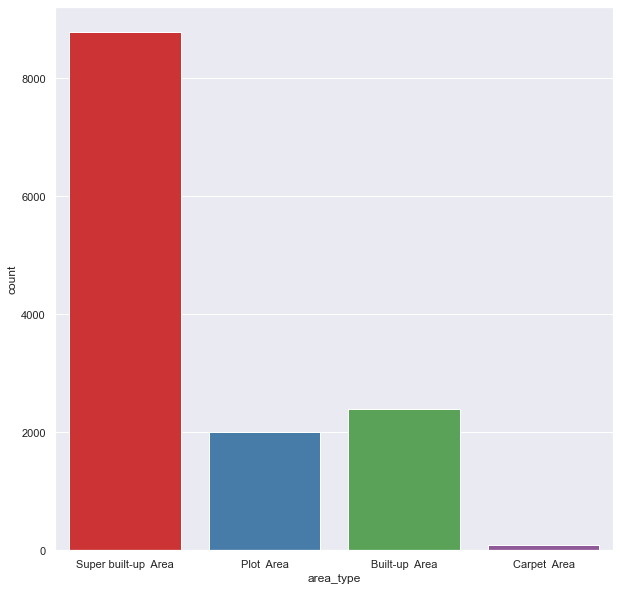

In [29]:
plt.figure(figsize=(10,10))
sns.set_context("talk", font_scale=0.8)
sns.set(style='darkgrid',palette='Set1')
sns.countplot(x='area_type',data=df)
print(df.area_type.value_counts(normalize=True),'\n')
print('='*120)
plt.show()

___We see that 66% of the areas were Super built-up  Area and Carpet  Area accounted for less than 1% in the area types of the different houses in Banglore, India___

#### Correlation with the target variable

In [30]:
## Let us see the correlation
cor_cols = [x for x in df.columns if x!='price']
corr = df[cor_cols].corrwith(df.price).to_frame()

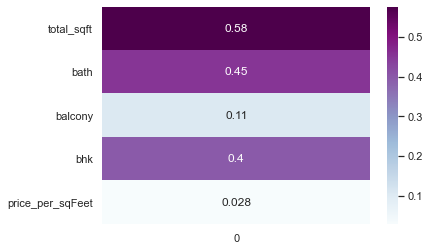

In [31]:
corr_mat = sns.heatmap(corr,annot=True,cmap='BuPu')

* So we note that total square feet has some decent correlation with the target variable which is price which makes sense as the pricing does depend on how big the house is.

In [32]:
fig = px.pie(df,names='area_type',values='balcony',title='Balconies per area type')
fig.show()

In [33]:
fig = px.scatter(df,x='total_sqft',y='price',title='Relationship between the price and Total sq.feet')
fig.show()

* We see a positive and nearly linear relation between the two variables along with some sure short outliers.

## Outlier Detection & Removal

__We assume that, on an average, a 2BHK house would be 600 sq.feet i.e each bedroom would range up to at least 300 sq. feet. If we have a 5 bhk house with 33 sq. feet of total area or we can say a house with bedroom ranging up to 60 sq. feet only then it means that it is inconsistent with the regular norms and is an anomaly. We could remove such outliers by taking 350 sq. feet per bedroom as our threshold__

In [128]:
df[df.total_sqft/df.bhk < 350].head(3)

,area_type,location,total_sqft,bath,balcony,price,bhk,price_per_sqFeet
9,Plot Area,Other,1020.0,6.0,2.0,370.0,6,36274.509804
26,Super built-up Area,Electronic City,660.0,1.0,1.0,23.1,2,3500.000000
29,Super built-up Area,Electronic City,1025.0,2.0,1.0,47.0,3,4585.365854


In [129]:
## we remove these from our data set
print(df.shape[0])
df = df[~(df.total_sqft/df.bhk < 350)]
print(df.shape[0])

13274
12180


### Outlier Removal Using Standard Deviation and Mean

In [130]:
df.price_per_sqFeet.describe()

count     12180.000000
mean       6180.567020
std        4014.487780
min         267.829813
25%        4200.000000
50%        5262.147304
75%        6800.000000
max      176470.588235
Name: price_per_sqFeet, dtype: float64

* __Here we find that min price per sqft is 267 rs/sqft whereas max is 1.76mm rs/sqft, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation__
* __First we check if the price_per_sqFeet is actually normally distributed or not__

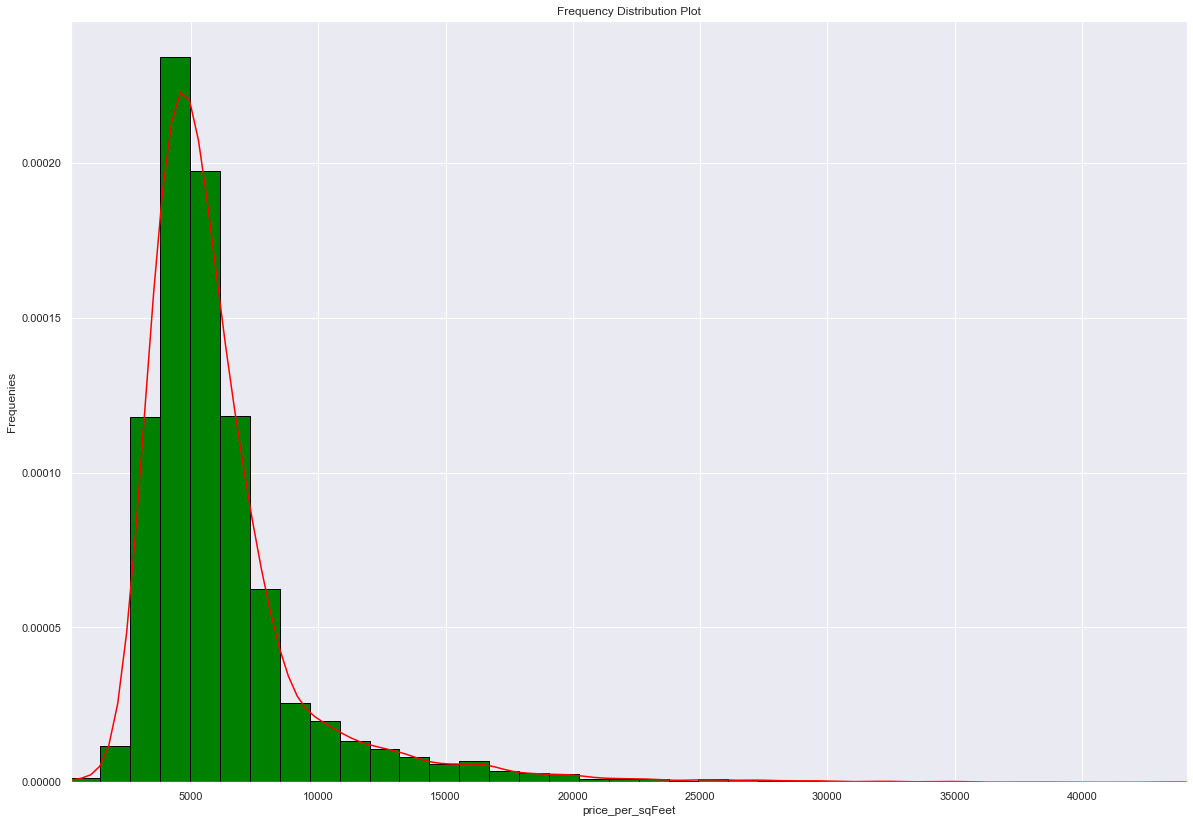

In [131]:
def plot_frequency(df,i:str):
    fig = plt.figure(figsize=(20,14))
    df[i].plot.kde(color='r')
    df[i].plot.hist(color='g',edgecolor='k',bins=150,density=True)
    plt.xlabel(i)
    plt.ylabel('Frequenies')
    plt.title('Frequency Distribution Plot')
    plt.ticklabel_format(style = 'plain', axis = 'y') 
    plt.ticklabel_format(style = 'plain', axis = 'x')
    plt.xlim(df[i].min(),df[i].max()/4)
    plt.show()
    
plot_frequency(df,'price_per_sqFeet')

* __Hence we observe that it is not exactly normal and is right skewed. So we remove our outliers which might make it more normal.__

In [132]:
## We define a function
print(df.shape)
def remove_outliers(df):
    df_res = pd.DataFrame()
    for k,subdf in df.groupby('location'):
        mean = np.mean(subdf.price_per_sqFeet)
        std = np.std(subdf.price_per_sqFeet)
        reduced_df = subdf[(subdf.price_per_sqFeet>(mean-std)) & (subdf.price_per_sqFeet<=(mean+std))]
        df_res = pd.concat([df_res,reduced_df],axis=0,ignore_index=True)
    return df_res

df = remove_outliers(df)
print(df.shape)
print('='*120)
df.head()

(12180, 8)
(9906, 8)


,area_type,location,total_sqft,bath,balcony,price,bhk,price_per_sqFeet
0,Super built-up Area,Devarachikkanahalli,1250.0,2.0,3.0,44.0,3,3520.000000
1,Super built-up Area,Devarachikkanahalli,1250.0,2.0,2.0,40.0,2,3200.000000
2,Plot Area,Devarachikkanahalli,1200.0,2.0,2.0,83.0,2,6916.666667
3,Super built-up Area,Devarachikkanahalli,1170.0,2.0,2.0,40.0,2,3418.803419
4,Super built-up Area,Devarachikkanahalli,1425.0,2.0,2.0,65.0,3,4561.403509


### Outlier Removal Using Bathrooms Feature

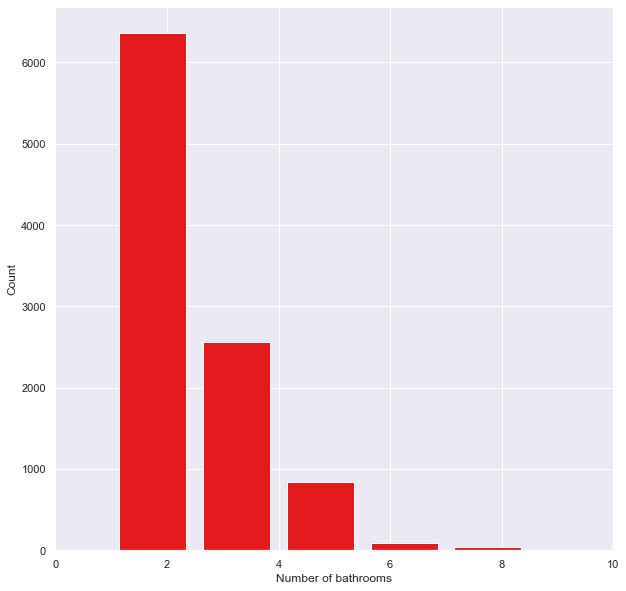

In [133]:
plt.figure(figsize = (10,10))
plt.hist(df.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")
plt.xlim(0,10)
plt.show()

In [134]:
df[df.bath>10]

,area_type,location,total_sqft,bath,balcony,price,bhk,price_per_sqFeet
5091,Super built-up Area,Neeladri Nagar,4000.0,12.0,2.0,160.0,10,4000.000000
5725,Super built-up Area,Other,12000.0,12.0,3.0,525.0,10,4375.000000
5809,Super built-up Area,Other,10000.0,16.0,1.0,550.0,16,5500.000000
6511,Super built-up Area,Other,6000.0,12.0,3.0,150.0,11,2500.000000
6831,Super built-up Area,Other,5425.0,13.0,0.0,275.0,13,5069.124424


__Though it is unusual to have 10 bathrooms in a house, but if your total area is quite large with equivalent number of rooms then having many bathrooms is a definite possibility__

### So if you have 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed

In [135]:
print(df.shape[0])
df = df[df.bath<df.bhk+2]
print('='*120)
df.shape[0]

## Hence we remove almost 100 data points with such a philosophy.

9906


9810

## One hot encoding for the Categoricals

In [136]:
cat_cols = ['area_type','location']
df.shape

(9810, 8)

In [137]:
df.head()

,area_type,location,total_sqft,bath,balcony,price,bhk,price_per_sqFeet
0,Super built-up Area,Devarachikkanahalli,1250.0,2.0,3.0,44.0,3,3520.000000
1,Super built-up Area,Devarachikkanahalli,1250.0,2.0,2.0,40.0,2,3200.000000
2,Plot Area,Devarachikkanahalli,1200.0,2.0,2.0,83.0,2,6916.666667
3,Super built-up Area,Devarachikkanahalli,1170.0,2.0,2.0,40.0,2,3418.803419
4,Super built-up Area,Devarachikkanahalli,1425.0,2.0,2.0,65.0,3,4561.403509


In [144]:
np.where(df.columns==' Devarachikkanahalli')[0][0]

10

In [138]:
ohe = OneHotEncoder()
le = LabelEncoder()
for col in cat_cols:
    
    new_arr = ohe.fit_transform(df[[col]]).toarray()
    labels = ohe.categories_[0]
    df.drop(col,axis=1,inplace=True)
    new_df = pd.DataFrame(new_arr,index=df.index,columns=labels)
    df = pd.concat([df,new_df],axis=1)
    


In [143]:
df.shape

(9810, 251)

In [91]:
type(df.columns[200])

tuple

In [43]:
ohe = OneHotEncoder()
le = LabelEncoder()
for col in cat_cols:
    
    #Integer encode the strting categories
    d = le.fit_transform(df[col]) #--This will give numeric values and a 1-D array
    
    #One hot encode
    new_d = ohe.fit_transform(d.reshape(d.shape[0],1))#A 2D array is required for one hot encoding, also this gives a sparse array.
    
    #Remove the original column
    df.drop([col],axis=1,inplace=True)
    
    #Give new column names
    col_names = ['_'.join([col,str(z)]) for z in range(new_d.shape[1])]
    
    #create new dataframe
    new_df = pd.DataFrame(new_d.toarray(),index=df.index,columns=col_names)
    
    #Concatenate the two dataframes
    df = pd.concat([df,new_df],axis=1)

In [44]:
df.shape

(9811, 251)

## Fitting the model

#### Train and Test splitting

In [45]:
df['price_per_sqFeet'] = round(df.price_per_sqFeet,2)
df.head()
# df.drop('price_per_sqFeet',axis=1,inplace=True)

,total_sqft,bath,balcony,price,bhk,price_per_sqFeet,area_type_0,area_type_1,area_type_2,area_type_3,...,location_231,location_232,location_233,location_234,location_235,location_236,location_237,location_238,location_239,location_240
0,1250.0,2.0,3.0,44.0,3,3520.00,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1250.0,2.0,2.0,40.0,2,3200.00,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1200.0,2.0,2.0,83.0,2,6916.67,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1170.0,2.0,2.0,40.0,2,3418.80,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1425.0,2.0,2.0,65.0,3,4561.40,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
cols = [x for x in df.columns if x!='price']
x = df[cols]
y=df['price']

##Splitting the data

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [47]:
x_train.head()

,total_sqft,bath,balcony,bhk,price_per_sqFeet,area_type_0,area_type_1,area_type_2,area_type_3,location_0,...,location_231,location_232,location_233,location_234,location_235,location_236,location_237,location_238,location_239,location_240
4140,1069.0,2.0,2.0,2,5145.00,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1369,1820.0,3.0,2.0,3,5109.89,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5703,960.0,2.0,2.0,2,3333.33,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8697,1884.0,4.0,2.0,3,6210.19,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6258,2108.0,3.0,3.0,3,4032.26,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### We would have to perform feature scaling to avoid bizzare results after model fitting

In [48]:
s = MinMaxScaler()

x_train[['total_sqft']] = s.fit_transform(x_train[['total_sqft']])
x_test[['total_sqft']] = s.transform(x_test[['total_sqft']])

In [49]:
x_train[['price_per_sqFeet']] = s.fit_transform(x_train[['price_per_sqFeet']])
x_test[['price_per_sqFeet']] = s.transform(x_test[['price_per_sqFeet']])

In [50]:
x_train.describe()

,total_sqft,bath,balcony,bhk,price_per_sqFeet,area_type_0,area_type_1,area_type_2,area_type_3,location_0,...,location_231,location_232,location_233,location_234,location_235,location_236,location_237,location_238,location_239,location_240
count,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,...,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000
mean,0.038308,2.431957,1.599388,2.542813,0.186365,0.189730,0.005224,0.064093,0.740953,0.001019,...,0.003058,0.000510,0.000382,0.003568,0.050586,0.001147,0.017202,0.003313,0.000892,0.006498
std,0.029714,0.894004,0.792992,0.859108,0.091551,0.392112,0.072095,0.244934,0.438139,0.031913,...,0.055219,0.022572,0.019549,0.059628,0.219165,0.033847,0.130031,0.057466,0.029854,0.080356
min,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.025291,2.000000,1.000000,2.000000,0.128978,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.031115,2.000000,2.000000,2.000000,0.168039,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.043095,3.000000,2.000000,3.000000,0.219012,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,16.000000,3.000000,16.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Linear Regression - The baseline model

In [51]:
lr = LinearRegression()
lr.fit(x_train,y_train)
pred = lr.predict(x_test)
pred_train = lr.predict(x_train)

In [52]:
r2_score(y_train,pred_train)

0.9267809475799309

In [53]:
r2_score(y_test,pred)

-3.034006307819829e+19

### The coefficient of determination that should be maximized, is computed as a negative score which means that our model is not performing good

__The linear regression model could be considered as a baseline model. It is performing well on the training data but it has become worse on the testing data which gives us a hint of `Overfitting`. In order to combat overfitting, we might just introduce a regularization parameter. We perform Ridge regression to check if we have better results on the unseen data like the test data in our case.__

### Ridge Regression

In [54]:
from sklearn.linear_model import RidgeCV

alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]

ridgeCV = RidgeCV(alphas=alphas, 
                  cv=4).fit(x_train, y_train)

ridgeCV_r2 = r2_score(y_test, ridgeCV.predict(x_test))
ridge_pred = ridgeCV.predict(x_test)

print(ridgeCV.alpha_,'\n',ridgeCV_r2)

0.05 
 0.9369927049269695


__So with alpha=0.05, as our best regularized parameter after performing cross validation on the trainig data, we see drastic imporvements in the results on our test data.__

### Below we also look at the `mean absolute errors` and see if we could minimize the same with linear and ridge regressions

In [76]:
errors_df = pd.DataFrame({
    'linear': [mean_absolute_error(y_train,pred_train), mean_absolute_error(y_test,pred)],
    "ridge":[mean_absolute_error(y_train,ridgeCV.predict(x_train)),mean_absolute_error(y_test,ridge_pred)]
},index=['Training errors','Test errors'])
errors_df

,linear,ridge
Training errors,9.440280e+00,9.428168
Test errors,1.353713e+10,9.680603


### Use GridSearchCV for the best model

In [81]:
x.head(3)

,total_sqft,bath,balcony,bhk,price_per_sqFeet,area_type_0,area_type_1,area_type_2,area_type_3,location_0,...,location_231,location_232,location_233,location_234,location_235,location_236,location_237,location_238,location_239,location_240
0,1250.0,2.0,3.0,3,3520.00,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1250.0,2.0,2.0,2,3200.00,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1200.0,2.0,2.0,2,6916.67,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
## first we scale our data as this time we are not gonna use splits
x_scaled = x.copy()
x_scaled[['total_sqft']] = s.fit_transform(x_scaled[['total_sqft']])
x_scaled[['price_per_sqFeet']] = s.fit_transform(x_scaled[['price_per_sqFeet']])
x_scaled.head(3)

,total_sqft,bath,balcony,bhk,price_per_sqFeet,area_type_0,area_type_1,area_type_2,area_type_3,location_0,...,location_231,location_232,location_233,location_234,location_235,location_236,location_237,location_238,location_239,location_240
0,0.029950,2.0,3.0,3,0.097593,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.029950,2.0,2.0,2,0.083836,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.028286,2.0,2.0,2,0.243625,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
## Defining a function

def find_the_best_model(x,y):
    algos = {
        'lasso':{
            'model': Lasso(),
            'params': {
                'alpha':[0.005, 0.05, 0.1, 0.3, 1, 3, 5]
            }
        },
        
        'Decision Tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'max_depth':[50,100],
                'criterion' : ['squared_error','friedman_mse']
            }
        },
        
        'Xtreme GBM': {
            'model': XGBRegressor(),
            'params': {
                'gamma': [0.5, 1, 1.5, 2,3,4,5],
                'subsample': [0.6, 0.8, 1.0],
                'max_depth': [3, 4, 5]
            }
        },
        
        'Light GBM': {
            'model': LGBMRegressor(),
            'params': {
                'gamma': [0.5, 1, 1.5, 2,3,4,5],
                'subsample': [0.6, 0.8, 1.0],
                'max_depth': [3, 4, 5]
            }
        }
    }
    
    cv = KFold(n_splits=4,shuffle=True,random_state=42)
    scores = []
    
    for algo_name, args in algos.items():
        gs = GridSearchCV(args['model'],args['params'], n_jobs=-1, cv=cv, return_train_score=False)
        gs.fit(x,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
        
    return pd.DataFrame(scores,columns=['model','best_score','best_params'])
        

In [96]:
## Invoking the function
find_the_best_model(x_scaled,y)

,model,best_score,best_params
0,lasso,0.922217,{'alpha': 0.005}
1,Decision Tree,0.956092,"{'criterion': 'friedman_mse', 'max_depth': 50}"
2,Xtreme GBM,0.969400,"{'gamma': 5, 'max_depth': 3, 'subsample': 1.0}"
3,Light GBM,0.892784,"{'gamma': 0.5, 'max_depth': 3, 'subsample': 0.6}"


>> __We observe that Xtreme Gradient Boosting model has the best score and we could consider the same for making our predictions.__

__Note that we have not used Random forest with Grid Search as it is a bit computationally expensive hence we use that the random forest regressor with RandomizedSearchCV__

In [97]:
cv = KFold(n_splits=4,shuffle=True,random_state=42)
est = RandomForestRegressor()
params = {'max_depth':[None,10,20,50,100],
          'max_features':[20,40,60,70,80]
         }

rf_clf = RandomizedSearchCV(est,params,n_jobs=-1,cv=cv, return_train_score=False)
rf_clf.fit(x_scaled,y)

RandomizedSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
                   estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 50, 100],
                                        'max_features': [20, 40, 60, 70, 80]})

In [101]:
## We check the score and the best parameters
pd.Series({
    'model': 'Random Forest Regressor',
    'best params': rf_clf.best_params_,
    'best score': rf_clf.best_score_,
    'best estimator': rf_clf.best_estimator_
},name='Values').to_frame()

,Values
model,Random Forest Regressor
best params,"{'max_features': 80, 'max_depth': None}"
best score,0.919893
best estimator,"(DecisionTreeRegressor(max_features=80, random..."


### Hence the XG Boost is giving us the highest accuracy and would seemingly give us good prediction accuracy. So we train our XGBM classifier based on our findings.

In [105]:
best_clf = XGBRegressor(max_depth = 3, gamma = 5, subsample = 1, n_jobs=-1)
best_clf.fit(x_scaled,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=5, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [107]:
x_scaled.columns

Index(['total_sqft', 'bath', 'balcony', 'bhk', 'price_per_sqFeet',
       'area_type_0', 'area_type_1', 'area_type_2', 'area_type_3',
       'location_0',
       ...
       'location_231', 'location_232', 'location_233', 'location_234',
       'location_235', 'location_236', 'location_237', 'location_238',
       'location_239', 'location_240'],
      dtype='object', length=250)

In [114]:
np.where(x_scaled.columns=='location_232')[0][0]

241